# MLP
Laden des auf IDS18 trainierten Modells  
Test auf IDS17

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import joblib
from sklearn.metrics import classification_report, confusion_matrix

2024-11-19 14:01:33.008195: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 14:01:33.030729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 14:01:33.047187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 14:01:33.051896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 14:01:33.069947: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='32_cnn_test.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [3]:
# Datensatz einlesen
df = pd.read_parquet(ids17_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-19 14:01:34 - INFO - Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Name: count, dtype: int64


(1923063, 52)
Index(['Fwd IAT Total', 'Dst Port', 'FIN Flag Count', 'Packet Length Variance',
       'Down/Up Ratio', 'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'URG Flag Count', 'Bwd Packets/s', 'Total TCP Flow Time',
       'Bwd Bulk Rate Avg', 'Total Length of Fwd Packet', 'Bwd IAT Mean',
       'Bwd Packet/Bulk Avg', 'Fwd IAT Max', 'Protocol', 'Flow IAT Min',
       'Bwd Header Length', 'Active Max', 'Total Fwd Packet',
       'Subflow Bwd Packets', 'Fwd Header Length', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Idle Std', 'Fwd Packet Length Min',
       'Bwd Init Win Bytes', 'Bwd Packet Length Std', 'RST Flag Count',
       'Fwd Act Data Pkts', 'Subflow Fwd Packets', 'ECE Flag Count',
       'SYN Flag Count', 'Bwd URG Flags', 'Average Packet Size', 'Bwd IAT Max',
       'Bwd PSH Flags', 'Total Length of Bwd Packet', 'Bwd RST Flags',
       'Flow Bytes/s', 'Fwd Bulk Rate Avg', 'Fwd IAT Min', 'Active Std',
       'Packet Length Max', 'Bwd IAT Total', 'Fwd IAT Mean',

### Trennen von Features und Labels

In [4]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (1923063, 51)
Form von y: (1923063,)


### Label Encoding für y

In [5]:
label_encoder = joblib.load('label_encoder.pkl')
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Skallierung von X

In [6]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.fit_transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (1923063, 51)
Form von X_scaled: (1923063, 51)


In [7]:
X_test, y_test = X_scaled, y_encoded
X_test.shape, y_test.shape

((1923063, 51), (1923063,))

### Überprüfen der Klassenverteilung

In [8]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 1582561 Beispiele (82.29%)
  Klasse 1: 736 Beispiele (0.04%)
  Klasse 2: 95144 Beispiele (4.95%)
  Klasse 3: 7567 Beispiele (0.39%)
  Klasse 4: 158468 Beispiele (8.24%)
  Klasse 5: 3859 Beispiele (0.20%)
  Klasse 6: 71767 Beispiele (3.73%)
  Klasse 7: 2961 Beispiele (0.15%)



### Laden des Modells

In [9]:
model = keras.models.load_model('model.keras')

I0000 00:00:1732021302.801812  667676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732021302.883635  667676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732021302.883679  667676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732021302.885839  667676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732021302.885877  667676 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [10]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

I0000 00:00:1732021305.996134  667889 service.cc:146] XLA service 0x7f616c004be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732021305.996195  667889 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-19 14:01:46.000077: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-19 14:01:46.032568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  226/60096 ━━━━━━━━━━━━━━━━━━━━ 40s 669us/step  

I0000 00:00:1732021306.322560  667889 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60096/60096 ━━━━━━━━━━━━━━━━━━━━ 43s 701us/step


/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       0.84      0.96      0.89   1582561
                 Botnet Ares       0.03      0.06      0.04       736
              DDoS-LOIC-HTTP       0.00      0.00      0.00     95144
               DoS GoldenEye       0.00      0.01      0.01      7567
                    DoS Hulk       0.00      0.00      0.00    158468
               DoS Slowloris       0.72      0.90      0.80      3859
Infiltration - NMAP Portscan       0.94      0.62      0.74     71767
              SSH-BruteForce       0.00      0.00      0.00      2961

                    accuracy                           0.81   1923063
                   macro avg       0.32      0.32      0.31   1923063
                weighted avg       0.73      0.81      0.77   1923063



/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualisierung der Konfusionsmatrix

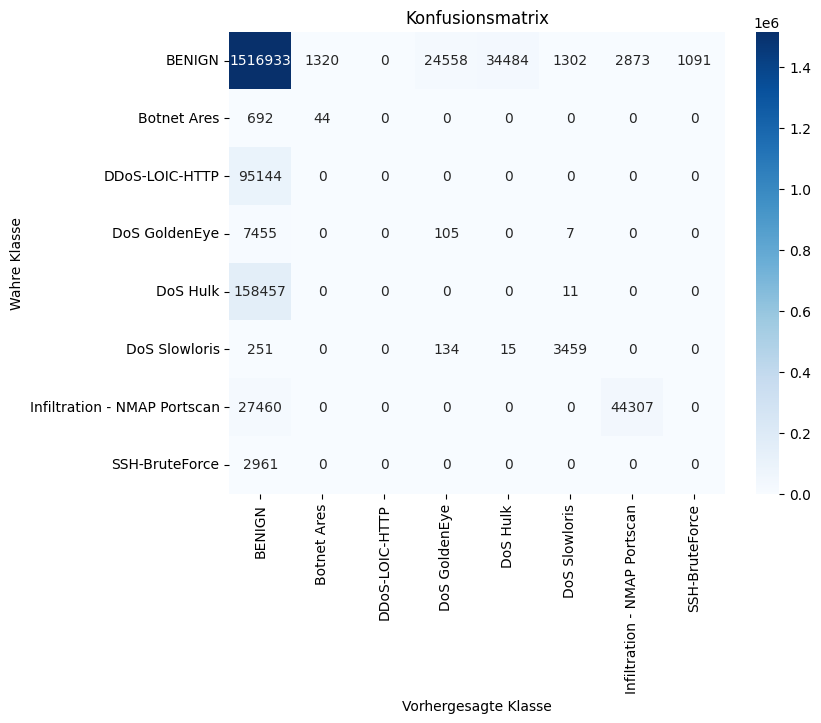

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
